In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.sign import UnarySign
from UnarySim.sw.kernel.abs import UnaryAbs
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def test(rng="Sobol", 
         mode="bipolar", 
         bitwidth=8, 
         total_cnt=100, 
         depth=5, 
         shiftreg=False
        ):
    stype = torch.float
    rtype = torch.float
    
    print("========================================================")
    print(mode)
    print("========================================================")
    # all input values are non-negative
    low_bound = 0
    if mode is "unipolar":
        up_bound = 2**bitwidth
    elif mode is "bipolar":
        low_bound = -2**(bitwidth-1)
        up_bound = 2**(bitwidth-1)

    input_list = []
    for input_val in range(low_bound, up_bound+1, 1):
        input_list.append(input_val)
    
    input = torch.tensor(input_list).type(torch.float).div(up_bound).to(device)
    
    output = torch.lt(input, 0).type(torch.float).to(device)

    result_pe_total = []
    for rand_idx in range(1, total_cnt+1):
        outputPE = ProgressiveError(output, mode="unipolar").to(device)
    
        inputPE  = ProgressiveError(input,  mode=mode).to(device)
        inputSRC = SourceGen(input, bitwidth, mode=mode, rtype=rtype)().to(device)

        dut = UnarySign(depth=depth, shiftreg=shiftreg).to(device)
        
        inputRNG = RNG(bitwidth, rand_idx, rng, rtype)().to(device)
        inputBS = BSGen(inputSRC, inputRNG, stype).to(device)
        with torch.no_grad():
            start_time = time.time()
            for i in range(2**bitwidth):
                input_bs = inputBS(torch.tensor([i]))
                inputPE.Monitor(input_bs)

                output_bs = dut(input_bs)
                outputPE.Monitor(output_bs)
        
        # get the result for different rng
        result_pe = outputPE()[1].cpu().numpy()
        result_pe_total.append(result_pe)
    
    # get the result for different rng
    result_pe_total = np.array(result_pe_total)
    
    #######################################################################
    # check the error of all simulation
    #######################################################################
    print("RMSE:{:1.4}".format(np.sqrt(np.mean(result_pe_total**2))))
    print("MAE: {:1.4}".format(np.mean(np.abs(result_pe_total))))
    print("bias:{:1.4}".format(np.mean(result_pe_total)))
    print("max: {:1.4}".format(np.max(result_pe_total)))
    print("min: {:1.4}".format(np.min(result_pe_total)))

    #######################################################################
    # check the error according to input value
    #######################################################################
    max_total = np.max(result_pe_total, axis=0)
    min_total = np.min(result_pe_total, axis=0)
    avg_total = np.mean(result_pe_total, axis=0)
    
    axis_len = outputPE()[1].size()[0]
    input_x_axis = []
    for axis_index in range(axis_len):
        input_x_axis.append((axis_index/(axis_len-1)*(up_bound-low_bound)+low_bound)/up_bound)
    fig, ax = plt.subplots()
    ax.fill_between(input_x_axis, max_total, avg_total, facecolor="red", alpha=0.75)
    ax.fill_between(input_x_axis, avg_total, min_total, facecolor="blue", alpha=0.75)
    ax.plot(input_x_axis, avg_total, label='Avg error', color="black", linewidth=0.3)
    plt.tight_layout()
    plt.xlabel('Input value')
    plt.ylabel('Output error')
    plt.xticks(np.arange(-1.1, 1.1, step=0.5))
    # ax.xaxis.set_ticklabels([])
    plt.xlim(-1, 1)
    plt.yticks(np.arange(-1.1, 1.1, step=0.2))
    # ax.yaxis.set_ticklabels([])
    plt.ylim(-1, 1)
    plt.grid(b=True, which="both", axis="y", linestyle="--", color="grey", linewidth=0.3)
    fig.set_size_inches(2, 2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()
    plt.close()

bipolar
RMSE:0.04875
MAE: 0.005745
bias:9.12e-05
max: 0.75
min: -0.1641


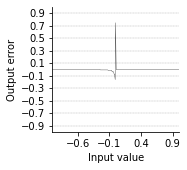

bipolar
RMSE:0.1001
MAE: 0.04735
bias:-0.0299
max: 0.3711
min: -0.5625


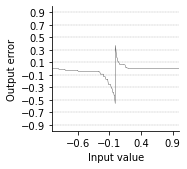

bipolar
RMSE:0.07907
MAE: 0.02364
bias:-0.004636
max: 0.2031
min: -0.7773


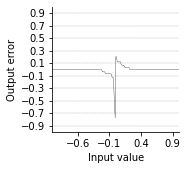

In [5]:
test(rng="Sobol", mode="bipolar", bitwidth=8, total_cnt=1, depth=5, shiftreg=False)
test(rng="LFSR", mode="bipolar", bitwidth=8, total_cnt=1, depth=5, shiftreg=False)
test(rng="SYS", mode="bipolar", bitwidth=8, total_cnt=1, depth=5, shiftreg=False)

bipolar
RMSE:0.1989
MAE: 0.06759
bias:-0.06753
max: 0.007812
min: -0.9609


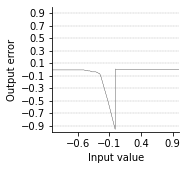

bipolar
RMSE:0.2462
MAE: 0.1784
bias:-0.04751
max: 0.3633
min: -0.6328


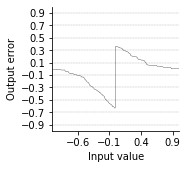

bipolar
RMSE:0.2209
MAE: 0.1385
bias:-0.06632
max: 0.3555
min: -0.6367


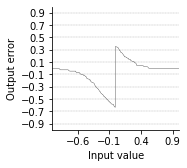

In [6]:
test(rng="Sobol", mode="bipolar", bitwidth=8, total_cnt=1, depth=8, shiftreg=True)
test(rng="LFSR", mode="bipolar", bitwidth=8, total_cnt=1, depth=8, shiftreg=True)
test(rng="SYS", mode="bipolar", bitwidth=8, total_cnt=1, depth=8, shiftreg=True)